In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
from newer_Galaxy import SpiralGalaxy

INFO: No release version set. Setting default to MPL-7


In [3]:
plt.style.use('seaborn')
plt.style.use('seaborn-colorblind')

In [4]:
usable_paths = np.load('usable_path_list.npy')

In [5]:
gal_objs = [SpiralGalaxy(path) for path in usable_paths]

/homes/sshamsi/.local/lib/python3.5/site-packages/marvin/tools/maps.py:272: MarvinUserWarning: mismatch between file version=DR15 and object release=MPL-7. Setting object release to DR15
  marvin.core.exceptions.MarvinUserWarning)
/homes/sshamsi/.local/lib/python3.5/site-packages/marvin/utils/general/general.py:354: MarvinUserWarning: more than one plate-ifu found for mangaid=1-211017. Using the one with the highest SN2.
  MarvinUserWarning)


In [6]:
mangaid_list = [gal.mangaid for gal in gal_objs]

In [7]:
for gal in gal_objs:
    gal.form_global_df()

In [8]:
for gal in gal_objs:
    gal.df['Mass'] = gal.mass
    
for gal in gal_objs:
    gal.df['$\lg{Mass}$'] = gal.lgmass
    
for gal in gal_objs:
    gal.df['MaNGA ID'] = gal.mangaid

In [9]:
for gal in gal_objs:
    map_ha = gal.maps.getMap('emline_gflux', channel='ha_6564')
    map_hb = gal.maps.getMap('emline_gflux', channel='hb_4862')

    ha_snr = map_ha.snr.flatten()
    hb_snr = map_hb.snr.flatten()

    gal.df['S/N $H_{\\alpha}$'] = ha_snr
    gal.df['S/N $H_{\\beta}$'] = hb_snr

In [10]:
df_list = [gal.df for gal in gal_objs]

spax_df = pd.concat(df_list)

In [11]:
spax_df = spax_df.dropna()
spax_df = spax_df[(spax_df.Comp == 0) & (spax_df.AGN == 0) & (spax_df.Seyfert == 0) & (spax_df.Liner == 0)]
spax_df = spax_df[(spax_df['$r/r_e$'] <= 1) & (spax_df['$r/r_e$'] >= 0.1)]
spax_df = spax_df[(spax_df['S/N $H_{\\alpha}$'] >= 3) & (spax_df['S/N $H_{\\beta}$'] >= 3)]

In [12]:
radial_bins = np.linspace(0.1, 1, 5)

radial_labels = []

for i in range(len(radial_bins) - 1):
    radial_labels.append((radial_bins[i] + radial_bins[i + 1]) / 2)

In [13]:
spax_df['Radial Bin'] = pd.cut(spax_df['$r/r_e$'], bins=radial_bins, labels=radial_labels)

In [14]:
cut, mass_bins = pd.qcut(spax_df['$\lg{Mass}$'], q=3, retbins=True)

In [15]:
mass_labels = [round((mass_bins[i] + mass_bins[i + 1]) / 2, 2) for i in range(3)]

In [16]:
spax_df['Mass Bin'] = pd.qcut(spax_df['$\lg{Mass}$'], q=3, labels=mass_labels)

In [17]:
def avg_relative_sfr(main_df, mangaid_list, gal_objs):
    ncoor_sfr_spiral, ncoor_sfr_var_spiral = [], []
    ncoor_sfr_nspiral, ncoor_sfr_var_nspiral = [], []
    
    unique_ids = main_df['MaNGA ID'].unique()
    
    tot_n_spiral, tot_n_nspiral = 0, 0
    
    for mangaid in unique_ids:
        df = main_df[main_df['MaNGA ID'] == mangaid]
        df_spiral = df[df['Spiral Arm'] == 1]
        df_nspiral = df[df['Spiral Arm'] == 0]
        
        n_spiral = len(df_spiral.index)
        n_nspiral = len(df_nspiral.index)
        
        index = mangaid_list.index(mangaid)
            
        if n_spiral > 0:
            sfr_spiral, sfr_spiral_stdv = gal_objs[index].get_sfr(df_spiral.index, avg=True)
            
            ncoor_sfr_spiral.append(sfr_spiral * n_spiral)
            ncoor_sfr_var_spiral.append((sfr_spiral_stdv**2) * n_spiral)
            
            tot_n_spiral += n_spiral
        
        if n_nspiral > 0:
            sfr_nspiral, sfr_nspiral_stdv = gal_objs[index].get_sfr(df_nspiral.index, avg=True)
            
            ncoor_sfr_nspiral.append(sfr_nspiral * n_nspiral)
            ncoor_sfr_var_nspiral.append((sfr_nspiral_stdv**2) * n_nspiral)
            
            tot_n_nspiral += n_nspiral
    
    avg_sfr_spiral = sum(ncoor_sfr_spiral) / tot_n_spiral
    avg_sfr_stdv_spiral = np.sqrt(sum(ncoor_sfr_var_spiral) / tot_n_spiral)
    
    avg_sfr_nspiral = sum(ncoor_sfr_nspiral) / tot_n_nspiral
    avg_sfr_stdv_nspiral = np.sqrt(sum(ncoor_sfr_var_nspiral) / tot_n_nspiral)
    
    rel_sfr = (avg_sfr_spiral - avg_sfr_nspiral) / avg_sfr_nspiral
    
    rel_sfr_stdv = rel_sfr * np.sqrt(((avg_sfr_stdv_spiral**2 + avg_sfr_stdv_nspiral**2) / (avg_sfr_spiral - avg_sfr_nspiral)**2)
                                     + (avg_sfr_stdv_nspiral / avg_sfr_nspiral)**2)
    
    return rel_sfr, rel_sfr_stdv

In [18]:
spax_df1 = spax_df[spax_df['Mass Bin'] == mass_labels[0]]
spax_df2 = spax_df[spax_df['Mass Bin'] == mass_labels[1]]
spax_df3 = spax_df[spax_df['Mass Bin'] == mass_labels[2]]

In [19]:
radial_rel_sfr = []
radial_rel_sfr_stdv = []

for radial_label in radial_labels:
    df = spax_df1[spax_df1['Radial Bin'] == radial_label]
    vals = avg_relative_sfr(df, mangaid_list, gal_objs)
    
    radial_rel_sfr.append(vals[0])
    radial_rel_sfr_stdv.append(vals[1])

In [20]:
radial_rel_sfr2 = []
radial_rel_sfr_stdv2 = []

for radial_label in radial_labels:
    df = spax_df2[spax_df2['Radial Bin'] == radial_label]
    vals = avg_relative_sfr(df, mangaid_list, gal_objs)
    
    radial_rel_sfr2.append(vals[0])
    radial_rel_sfr_stdv2.append(vals[1])

In [21]:
radial_rel_sfr3 = []
radial_rel_sfr_stdv3 = []

for radial_label in radial_labels:
    df = spax_df3[spax_df3['Radial Bin'] == radial_label]
    vals = avg_relative_sfr(df, mangaid_list, gal_objs)
    
    radial_rel_sfr3.append(vals[0])
    radial_rel_sfr_stdv3.append(vals[1])

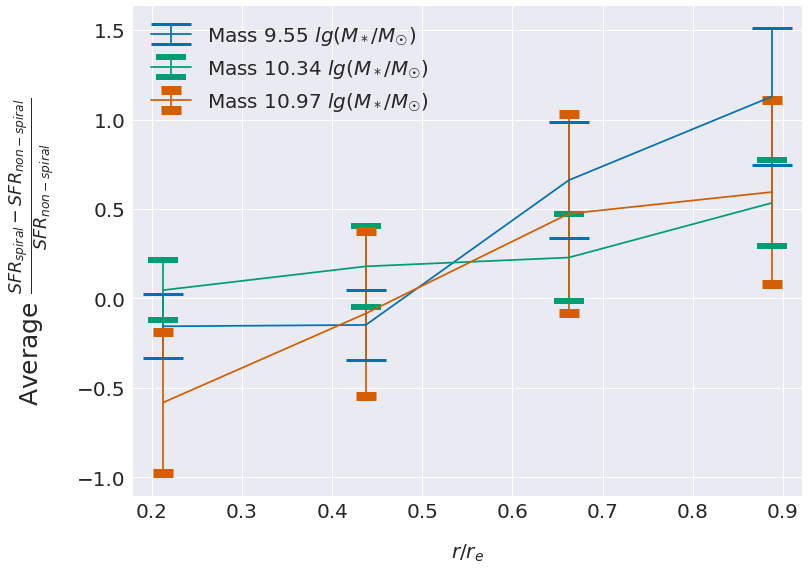

In [22]:
plt.figure(figsize=(12, 9))

plt.errorbar(radial_labels, radial_rel_sfr, yerr=radial_rel_sfr_stdv, label='Mass 9.55 $lg(M_*/M_☉)$', capsize=20,
             capthick=3)
plt.errorbar(radial_labels, radial_rel_sfr2, yerr=radial_rel_sfr_stdv2, label='Mass 10.34 $lg(M_*/M_☉)$', capsize=15,
             capthick=6)
plt.errorbar(radial_labels, radial_rel_sfr3, yerr=radial_rel_sfr_stdv3, label='Mass 10.97 $lg(M_*/M_☉)$', capsize=10,
             capthick=9)

plt.xlabel('$r/r_e$', labelpad=20, size=20)
plt.ylabel(r'Average $\frac{SFR_{spiral} - SFR_{non-spiral}}{SFR_{non-spiral}}$', labelpad=20, size=25)
plt.xticks(size=20)
plt.yticks(size=20)

plt.legend(fontsize=20)

In [43]:
mass_labels

[9.55, 10.34, 10.97]